# CP321-ILR: MidTerm

## DMP Theory

In a DMP, the demonstrated motion with one degree of freedom (DoF) is modeled as a spring-damper system.

\begin{equation*}
    \tau^2 \ddot{x} = \alpha_x(\beta_x(g-x)-\tau\dot{x})+f
\end{equation*}

where $x$ is the state of the system, $f$ is the forcing function that determines the nonlinear behavior, $\alpha_x$ and $\beta_x$ are constants that determine the damping and spring behavior, respectively. $\tau$ is a constant that determines the temporal behavior, and $g$ denotes the goal state.

The time is modelled by a phase variable $z$ as follows:
\begin{equation*}
    \tau \dot z = -\alpha_z z
\end{equation*}
In this case, the phase variable $z$ is given by a function of time $t$
\begin{equation*}
    z(t) = z_0 \exp \left( -\frac{\alpha_z}{\tau}t \right)
\end{equation*}
Typically, the phase variable  $z \in [0, 1]$.

Using a Gaussian basis function with this phase variable $z$, the forcing function $f$ can be formulated as
\begin{equation*}
    f(z) = (g-x_0)\sum_{i=1}^M\psi_i(z)w_iz
\end{equation*}
where $x_0$ denotes the initial position and $M$ the number of the basis
functions. The Gaussian basis function $\psi_i(z)$ is given by
\begin{equation*}
    \psi_i(z) = \frac{\exp(-h_i(z-c_i)^2)}{\sum_{j=1}^M \exp(-h_j(z-c_j)^2)}
\end{equation*}
where $h_i$ and $c_i$ are constants that determine the width and centers of
the basis functions, respectively.

$\textbf{Important Note(hyperparameters):}$ While implementing the basis functions make sure that the centers of the gaussians are equally spaced in time (not in phase domain) and $h_i = M/c_i$ , $z_0=1$ , $\beta_x=\frac{\alpha_x}{4}$ , $\alpha_z = \frac{\alpha_x}{3}$ and $\alpha_x=25$.

To obtain the weight parameters in a DMP, we compute the target value of the forcing function from the given trajectory as

\begin{equation*}
    f_{\text{target}}(z(t)) = \tau^2\ddot{x}^{\text{demo}}(t)-\alpha_x(\beta_x(g-x^{\text{demo}}(t))-\tau\dot{x}^{\text{demo}}(t))
\end{equation*}

where $x^{\text{demo}}(t), \dot{x}^{\text{demo}}(t), \ddot{x}^{\text{demo}}(t)$ are the position, velocity and acceleration at the time $t$, respectively.

We can find the weight vector by minimizing the sum of the squared error.

\begin{equation*}
    L_{\text{DMP}} = \sum_{t=0}^{T}(f_{\text{target}}(z(t))-f(z(t)))^2
\end{equation*}

by solving the least squares solution we get

\begin{equation*}
    w = (\Phi^\top \Phi)^{-1}\Phi^\top F
\end{equation*}

where $\Phi_{i,j} = \psi_j(z(t_i))*z(t_i)$ and

\begin{equation*}
    F = \left[ \frac{f_{\text{target}}(0)}{(g-x_0)},\cdots,\frac{f_{\text{target}}(t)}{(g-x_0)},\cdots,\frac{f_{\text{target}}(T)}{(g-x_0)} \right]
\end{equation*}

$\textbf{Important Note(dimensionality):}$ Since DMPs are primarily designed
for learning a motion for a single degree of freedom, multiple DMPs
need to be learned for each dimension when learning motions with multiple dimensions.

In [211]:
%reload_ext autoreload
%autoreload 2

from functools import partial
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from utils.models import DMP, BaseModelABC

In [ ]:
# HELPER FUNCTIONS


def plot_curves(x, show_start_end=True, **kwargs):
    """
    plots 2d curves of trajectories

    params:
        x: array of shape (number of curves,n_steps_per_curve,2)
    """
    if show_start_end:
        start_label, end_label = "start", "end"
    else:
        start_label, end_label = None, None
    for t in range(x.shape[0]):
        plt.scatter(x[t][0, 0], x[t][0, 1], c="k", label=start_label)
        plt.scatter(x[t][-1, 0], x[t][-1, 1], c="b", label=end_label)
        plt.plot(x[t][:, 0], x[t][:, 1], **kwargs)
        if t == 0:
            kwargs.pop("label", None)
            start_label, end_label = None, None

    plt.legend()


def streamplot(f, x_axis=(0, 100), y_axis=(0, 100), n=1000, width=1, **kwargs):
    """
    helps visualizing the vector field.

    params:
        f: function to predict the velocities in DS(Dynamical system : x_dot = f(x),x of shape (n_points,2),x_dot of shape (n_points,2))
        x_axis: x axis limits
        y_axis: y axis limits
        n: number of points in each axis (so total n*n predictions happen)
        width: width of the vector
        **kwargs: goes into plt.streamplot
    """
    a, b = np.linspace(x_axis[0], x_axis[1], n), np.linspace(y_axis[0], y_axis[1], n)
    X, Y = np.meshgrid(a, b)
    X_test = np.stack([X, Y], axis=-1).reshape(-1, 2)
    Y_pred = f(X_test)
    U, V = np.split(Y_pred.reshape(n, n, 2), 2, axis=-1)
    U, V = U[..., 0], V[..., 0]
    speed = np.sqrt(U**2 + V**2)
    lw = width * speed / speed.max()
    plt.streamplot(X, Y, U, V, linewidth=lw, **kwargs)


# loading the data and plotting
def load_data(letter):
    """
    gets the trajectories coresponding to the given letter

    params:
        letter: character in ["c","j","s"]

    returns:
        data: array of shape (number of trajectories,number of timesteps,2)
        x: array of shape(number of trajectories*number of timesteps,2)
        xd: array of shape(number of trajectories*number of timesteps,2)

    """
    letter2id = dict(c=2, j=6, s=24)
    assert letter.lower() in letter2id
    _, data, _, _, _, _ = load_lasa(letter2id[letter.lower()])
    return data

In [213]:
data = load_data("s")

# 1Q. Plot all the trajectories (10 Marks)

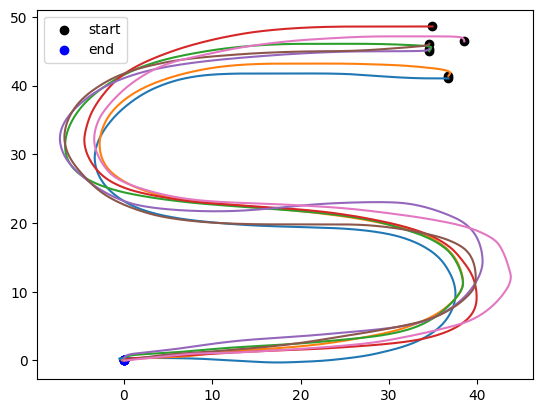

In [214]:
################################
plot_curves(data)
################################

In [215]:
# get a single trajectory from data
x = data[0]
x0, g = x[0], x[-1]

# 2Q. DMP Implemetation (50 Marks)

Please fill the code in the 'YOUR CODE HERE' section.

Information about the hyperparameters and theory is given in the question paper

In [216]:
# train the dmp model
alpha = 25
n_features = 10
dmp = DMP(alpha, n_features)
dmp.fit(x)

In [217]:
x.shape

(1000, 2)

Took 1.0289999999999975 seconds to reach the goal


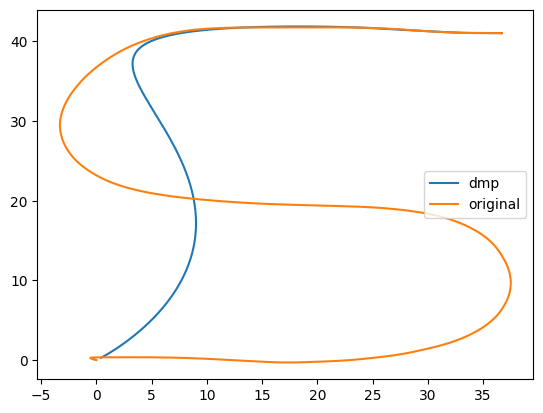

In [218]:
# imitation for training configuration
x0, g = x[0], x[-1]
tau = 1.0
dmp.imitate(x0, g, tau)

# 3Q. Spatial variation (15 Marks)

Try 5 different configurations of starting and goal positions and plot the generated trajectories. Comment on the generalization and stability.

In [219]:
################################

################################

# 4Q. Temporal variation (15 Marks)

From the training configuration($\textbf{x0}=x[0],\textbf{g}=x[-1]$), try $5$ different $\tau \gt 0$ (temporal parameter in the algorithm), some greater than 1 and some less than 1. Note down the approximate time taken for the generated trajectories to converge. Comment on the effect of temporal parameter.


In [220]:
################################

################################

# 5Q.
Discuss and compare the following methods in the context of dynamic movement primitives (DMPs): DMP, SEDS, ProMP, TP-GMM, and TP-GPT. In your answer, analyze how each method addresses two key aspects:

Stability: How does the method ensure convergence or robustness in generating movements?

Generalization: How effectively does the method adapt to variations or new conditions beyond the training demonstrations?

Present your analysis in a table format with the rows representing each method (DMP, SEDS, ProMP, TP-GMM, TP-GPT) and the columns for Stability and Generalization. Be sure to critically evaluate the strengths and weaknesses of each approach in these dimensions.. (10 Marks)